# Titanic Problem

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on

In [1]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()    

In [107]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [108]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [109]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [110]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

#train_data = train_data[train_data['Embarked'].notnull()]

In [111]:
train_data_prepared = train_data.drop(["Name","Ticket","Cabin","Survived"], axis = 1)
train_labels = train_data["Survived"].copy()

Convert text fields to category

In [112]:
#train_data_prepared_cat = train_data_prepared[["Sex","Embarked"]]
#train_data_prepared_cat_f = train_data_prepared_cat[train_data_prepared_cat['Embarked'].notnull()]
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
#train_data_cat = cat_encoder.fit_transform(train_data_prepared_cat_f)
#train_data_cat.toarray()
train_data_prepared_num = train_data_prepared.drop(["Sex","Embarked"],axis = 1)

In [117]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_attribs = list(train_data_prepared_num)
cat_attribs = ["Sex","Embarked"]
#pipeline = ColumnTransformer([
#    ("imputer",SimpleImputer(strategy = "median"),num_attribs),
#    ("categorical_tranformer",OneHotEncoder(),cat_attribs)
num_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy = "median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy = "most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

pipeline = ColumnTransformer([
    ("num_pipeline",num_pipeline,num_attribs),
    ("cat_pipeline",cat_pipeline,cat_attribs)
])

In [118]:
titanic_prepared = pipeline.fit_transform(train_data_prepared)


In [121]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score,roc_auc_score, confusion_matrix,roc_curve
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
knn_clf = KNeighborsClassifier()
predicted = cross_val_predict(forest_clf,titanic_prepared,train_labels,cv = 10)
print("confusion matrix\n",confusion_matrix(predicted,train_labels))
print("precision",precision_score(predicted,train_labels))
print("recall",recall_score(predicted,train_labels))

confusion matrix
 [[476  91]
 [ 73 251]]
precision 0.7339181286549707
recall 0.7746913580246914


In [129]:
forest_scores = cross_val_score(forest_clf,titanic_prepared,predicted,cv = 10)

In [128]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf,titanic_prepared,predicted, cv=10)
predicted = cross_val_predict(svm_clf,titanic_prepared,train_labels,cv = 10)
confusion_matrix(predicted,train_labels)

#svm_scores.mean()

0.992134831460674

{'whiskers': [<matplotlib.lines.Line2D at 0x1e388cc2a58>,
 'caps': [<matplotlib.lines.Line2D at 0x1e388cc2ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e388cc26a0>,
 'medians': [<matplotlib.lines.Line2D at 0x1e388cca828>,
 'fliers': [<matplotlib.lines.Line2D at 0x1e388ccab70>,
 'means': []}

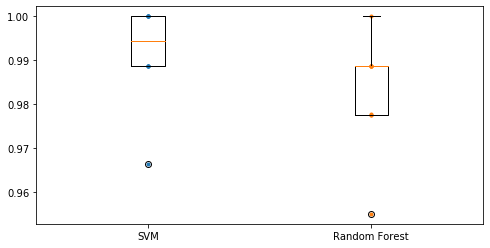

In [131]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))

In [104]:
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)        

0.7227820636451301

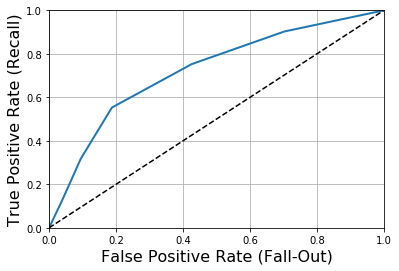

In [105]:
predicted_prob = cross_val_predict(knn_clf,titanic_prepared,train_labels,cv = 3,method = "predict_proba")
predicted_prob = predicted_prob[:,1]

fpr_forest,tpr_forest,threshold = roc_curve(train_labels,predicted_prob)
plot_roc_curve(fpr_forest,tpr_forest)
roc_auc_score(train_labels,predicted_prob)